### Import statements

In [1]:
%%capture

import numpy as np
import tensorflow as tf

#mandatory for correct load and save of files
%cd /Users/paolobonomi/work/python/capsnet

# for project class
import sys
sys.path.append("./src")

from setup import Setup # set up model and dataset
import perfu # performance function such as confusion matrix etc...
import printer

### Retrieve model and dataset

In [2]:
def _process_data(x, y, shuffle):
    x_ = x
    y_ = y

    x_ = x_ / 255.0
    x_ = tf.cast(x_, dtype=tf.float32)
    x_ = tf.expand_dims(x_, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices((x_, y_))
    if shuffle:

        dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size=64)
    return x_, y_, dataset

In [3]:
import scipy.io as spio
import numpy as np

#test set is 10k per batch, trainning set is 50k per batch

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        


def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def _unpack(dataset):
    ans_set = dataset['affNISTdata']['label_int']
    img_set = dataset['affNISTdata']['image']
    trans = dataset['affNISTdata']['human_readable_transform']
    
    img_set = np.transpose(img_set)
    img_set = np.reshape(img_set, (-1, 40, 40))
    ans_set = ans_set.astype(np.uint8)

    return img_set, ans_set, trans

def load(train):
    s = "training" if train else "test"

    if train:
        path = './data/affNIST/'+s+'_batches/1.mat'
        data = _unpack(loadmat(path))
    else:
        path = './data/affNIST/'+s+'_batches/1.mat'
        img_set, ans_set, trans = _unpack(loadmat(path))

    return img_set, ans_set, trans

def load_affnist_transformations(train):
    s = "training" if train else "test"

    if train:
        path = './data/affNIST/'+s+'_batches/1.mat'
        data = _unpack(loadmat(path))
    else:
        path = './data/affNIST/'+s+'_batches/1.mat'
        img_set, ans_set, trans = _unpack(loadmat(path))

    return trans

def load_MNIST(train):
    s = "training" if train else "test"
    path = './data/affNIST/originals/'+s+'.mat'
    img_set, ans_set, trans = _unpack(loadmat(path))
    return img_set, ans_set

In [12]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn

def convert_to_torch(img):
    rx = torch.from_numpy(img)
    rx = torch.unsqueeze(rx, 0)
    return rx

def convert_to_tensor(img):
    rx = tf.convert_to_tensor(img, dtype=tf.dtypes.float32)
    rx = np.reshape(rx, [1, 40, 40])
    return rx

def apply_scaling(img, x, y, mode):
    i = int(40*y)
    j = int(40*x)
    rx = fn.resize(img, size=[ i, j ], interpolation=mode)
    rx = fn.center_crop(rx, [40, 40])
    return rx

def apply_transformation(img, data, id, mode=transforms.InterpolationMode.NEAREST):
    rotation = data[0][id] #counter clock wise between -20 and +20
    shearing = data[1][id] #shearing between -0.2 and +0.2. if shear 1 horiz line turns into 45 degree line
    y_scale = data[2][id]
    x_scale = data[3][id] # between 0.8 (shrinking by 20%) and 1.2 (making 20% larger).
    v_trasl = data[4][id]
    h_trasl = data[5][id] # 
    
    rx = convert_to_torch(img)    
    rx = fn.affine(rx, rotation*-1, [0, 0], 1, [0, shearing*-45], interpolation=mode)
    rx = apply_scaling(rx, x_scale, y_scale, mode)
    rx = fn.affine(rx, 0, [h_trasl*0.4, v_trasl*0.4], 1, 0, interpolation=mode)

    rx = convert_to_tensor(rx)
    rx = tf.reshape(rx, [40, 40])
    return rx

def create_affnist(train):
    x, y = load_MNIST(train)
    t = load_affnist_transformations(train)

    for i in range(0, x.shape[0]): 
        x[i] = apply_transformation(x[i], t, i)
        
    return x, y

In [13]:
mnist = load_MNIST(False)
aff = load(False)
my_aff = create_affnist(False)

/var/folders/0c/9q8n75h10svg7r2mxtwpqt500000gn/T/ipykernel_79439/2922447800.py:23: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
/var/folders/0c/9q8n75h10svg7r2mxtwpqt500000gn/T/ipykernel_79439/2922447800.py:35: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):


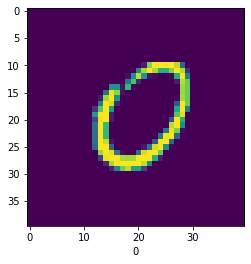

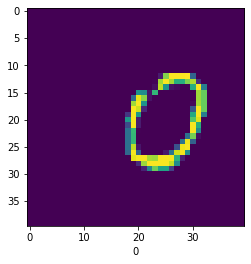

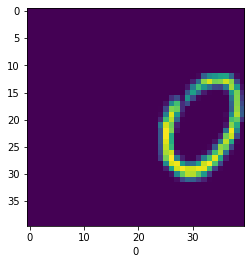

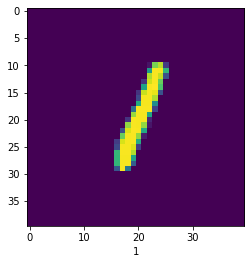

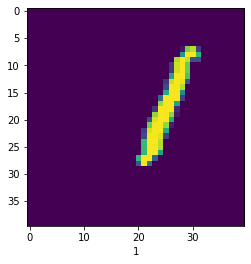

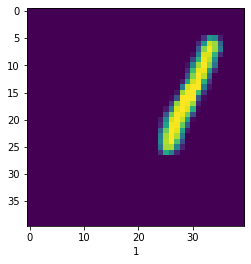

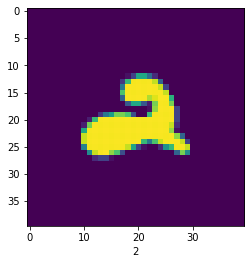

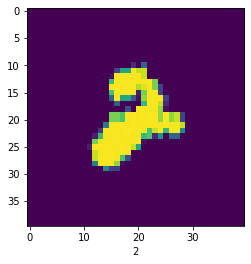

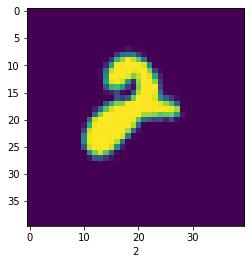

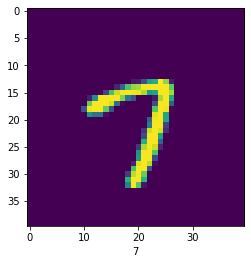

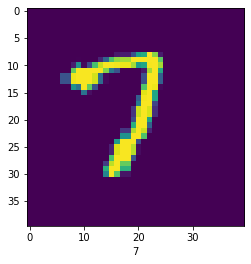

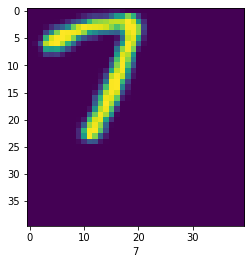

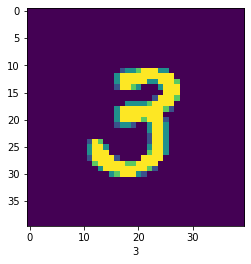

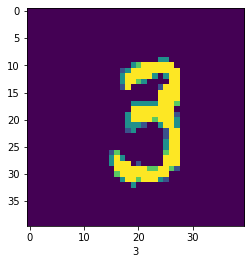

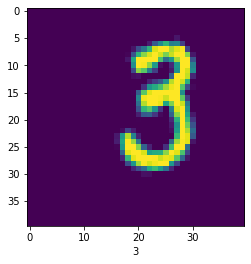

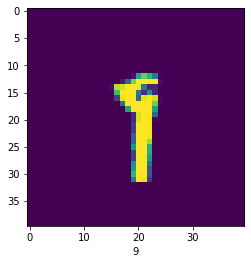

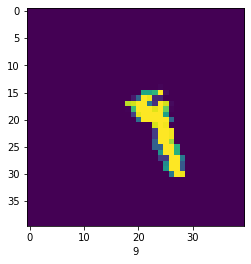

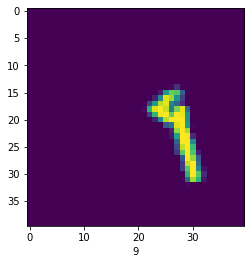

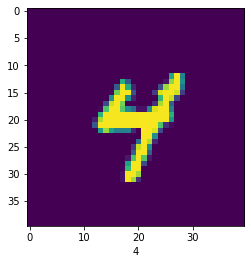

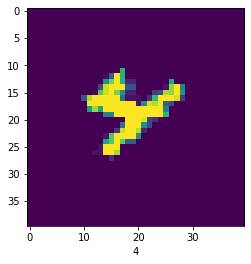

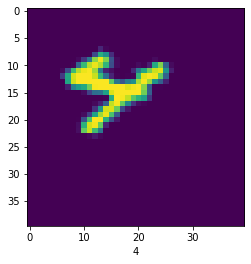

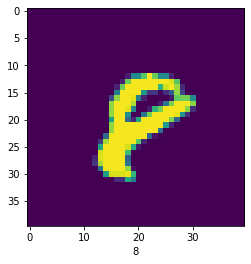

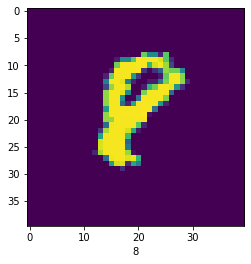

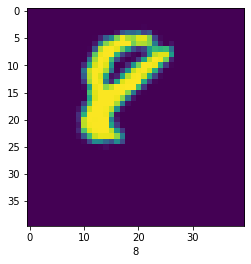

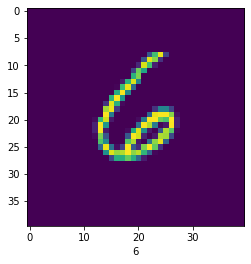

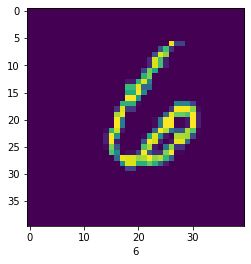

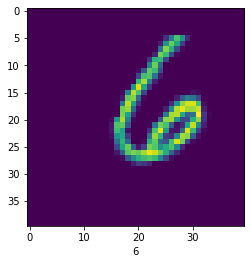

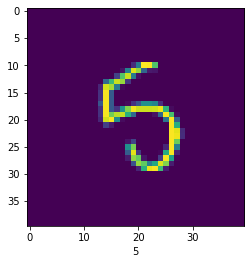

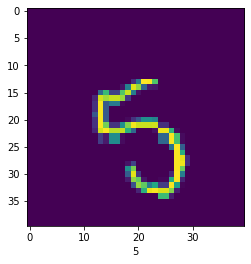

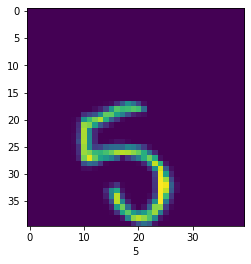

In [14]:
for id in range(0, 10):
    original_image = mnist[0][id]
    affnist_image = aff[0][id]
    my_image = my_aff[0][id]

    printer.print_image(original_image, mnist[1][id], 40)
    printer.print_image(my_image, my_aff[1][id], 40)
    printer.print_image(affnist_image, aff[1][id], 40)

# TEST IT

In [15]:
print(Setup.GEN)

['original_MNIST', 'affNIST', 'my_MNIST', 'Custom_affNIST', 'Custom_affNIST_without_shearing']


In [16]:
model_id = Setup.GEN[0]
model_version = "_3e-5"
dataset_version = "_v1"

setup = Setup()

#load original mnist dataset and model
x_t, y_t, b_t = setup.load_data(Setup.GEN[0], train=True, version=dataset_version, create=False)
model = setup.init_model(model_id, model_version, x_t, y_t)

#load affnist
x, y, b = setup.load_data(Setup.GEN[1], train=False, version=dataset_version, create=False)

#load mnist
x_2, y_2, b_2 = setup.load_data(Setup.GEN[0], train=False, version=dataset_version, create=False)

#recreate affnist
m_x, m_y = create_affnist(False)
m_x, m_y, m_b = _process_data(m_x, m_y, False) 

setup.load_ckpt(model, 1)

Found GPU at: /device:GPU:0
Load toronto MNIST training dataset... 
Processing data... 


2023-02-28 10:02:51.836655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 10:02:51.836834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-28 10:02:53.217534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Load AffNIST test dataset... 
Processing data... 
Load toronto MNIST test dataset... 
Processing data... 


/var/folders/0c/9q8n75h10svg7r2mxtwpqt500000gn/T/ipykernel_79439/2922447800.py:23: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
/var/folders/0c/9q8n75h10svg7r2mxtwpqt500000gn/T/ipykernel_79439/2922447800.py:35: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):


Loading model... 


In [17]:
#aff_acc = setup.get_accuracy(model, b, setup.get_total_images(x))
#print(aff_acc)
#  0.2143

In [18]:
#mnist_acc = setup.get_accuracy(model, b_2, setup.get_total_images(x_2))
#print(mnist_acc)
#  0.9915

In [19]:
my_aff_acc = setup.get_accuracy(model, m_b, setup.get_total_images(m_x))
print(my_aff_acc)

# interpolation mode BILINEAR = 0.2114
# interpolation mode NEAREST = 0.2127
# interpolation mode NEAREST = 0.2113 - no shearing
# interpolation mode NEAREST = 0.2189 - no scaling
# interpolation mode NEAREST = 0.9559 - no transaltion
# interpolation mode NEARESR = 0.8766 - traslation only at 0.2 percent then original
# interpolation mode NEARESR = 0.6259 - traslation only at 0.4 percent then original

Eval. accuracy : 100%|████████████████████████| 157/157 [08:02<00:00,  3.07s/it]

0.6259


In [ ]:
printer.print_image(m_x[0], 0, 40)

### Perfomance data

In [ ]:
printer.pretty_experiment_overview(setup)

In [ ]:
should_create_matrix = True
flag_only_test = True

In [ ]:
p_train = train_dataset_type.replace("_", " ")
p_test = test_dataset_type.replace("_", " ")

if should_create_matrix:
    %store -r matrix_dict
    
    if flag_only_test:
        cm_train = matrix_dict[str(epochs)+"_"+train_dataset_type]
    else:
        cm_train = perfu.get_confusion_mat(model.predict, dataset, "train")
        matrix_dict[str(epochs)+"_"+train_dataset_type] = cm_train
    
    cm_test = perfu.get_confusion_mat(model.predict, testing, "test")
    matrix_dict[str(epochs)+"_"+train_dataset_type+"_"+test_dataset_type] = cm_test
    
    %store matrix_dict
else:
    %store -r matrix_dict
    cm_test = matrix_dict[str(epochs)+"_"+train_dataset_type+"_"+test_dataset_type]
    cm_train = matrix_dict[str(epochs)+"_"+train_dataset_type]  
    
acc_train = perfu.get_accuracy(perfu.normalize_matrix( cm_train, no_train_images))
acc_test = perfu.get_accuracy(perfu.normalize_matrix( cm_test, no_test_images))

#### Testing Confusion Table

In [ ]:
values, columns, index = perfu.get_confusion_table(cm_test, no_test_images)
printer.print_confusion_tables(values, columns, index)

#### Confusion Matrix

In [ ]:
######## TRAIN

mat = cm_train
n = no_train_images
s = '{0} ({1} epochs)'.format(p_train, epochs)

printer.print_matrix( perfu.normalize_matrix(mat, n),
                        'Normalized on total images(%)', 
                        s, 
                        '{0} train'.format(p_train), 
                         n)

printer.print_matrix( perfu.normalize_matrix_on_row(mat),
                        'Normalized on on tot images in row(%)', 
                        s, 
                        '{0} train'.format(p_train),  
                         n,
                         row_labels=printer.get_sum_row_matrix_label(mat))

printer.print_matrix( perfu.normalize_matrix_on_columns(mat),
                        'Normalized on tot images in column(%)', 
                        s, 
                        '{0} train'.format(p_train),  
                         n,
                         col_labels=printer.get_sum_colum_matrix_label(mat))

####### TEST

mat = cm_test
n = no_test_images

printer.print_matrix( perfu.normalize_matrix(mat, n),
                        'Normalized on total images(%)', 
                        s, 
                        '{0} test'.format(p_test),  
                         no_test_images)

printer.print_matrix( perfu.normalize_matrix_on_row(mat),
                        'Normalized on on tot images in row(%)', 
                        s, 
                        '{0} test'.format(p_test),  
                         n,
                         row_labels=printer.get_sum_row_matrix_label(mat))

printer.print_matrix( perfu.normalize_matrix_on_columns(mat),
                        'Normalized on tot images in column(%)', 
                        s, 
                        '{0} test'.format(p_test),  
                         n,
                         col_labels=printer.get_sum_colum_matrix_label(mat))

#### Accuracy

In [ ]:
printer.print_accuracy(acc_train, acc_test, no_train_images, no_test_images, epochs)

### Error cases

In [ ]:
off = 44
n = 110
idx, pred = perfu.get_error_index(model, X_test[off:off+n], y_test[off:off+n], off)

print(idx)
print(pred)

In [ ]:
for i in range(len(idx)):
    img = idx[i]
    printer.print_image_and_prediction(X_test[img], y_test[img], pred[i], 40 )


### Network Conv1/PrimaryCapsule Output

In [ ]:
printer.print_network(model, X_test[45], y_test[45], 40)

### Network Kernels

In [ ]:
printer.print_fixed_network_params(model)